# **Predicting U.S. Crime Rates**

## **Discussion: LSTM**

---

In this notebook, we'll discuss the results of the Long Short-Term Memory Recurrent Neural Network [trained in Modeling](RNN_LSTM_Model.ipynb).

Start by importing a few important libraries:

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

#import the scores:
scores = pd.read_csv('../data/model_results/scores.csv')

#import the forecast:
forecast = pd.read_csv('../data/model_results/target_forecast.csv')

#import the rates:
predictions = pd.read_csv('../data/model_results/predictions.csv')

#import the predcitors and targets to help with plotting:
df = pd.read_csv('../data/model_inputs/predictors_and_targets.csv')

In [2]:
#to datetime format inspired by user Zero: https://stackoverflow.com/a/46658244
years = df.copy()
years = list(years['year'].unique())
years.append(years[-1]+1)
years = pd.to_datetime(np.array(years),format="%Y")

#set the years to a datetime format:
df['year'] = pd.to_datetime(df['year'], format = '%Y')

In [3]:
print(scores.shape)
scores.head()

(102, 8)


,state,crime_rate,baseline_MAE,baseline_RMSE,baseline_R2,LSTM_MAE,LSTM_RMSE,LSTM_R2
0,AL,violent_crime_1000,0.300871,0.421549,0.823228,0.481595,0.606492,0.634095
1,AL,property_crime_1000,0.309165,0.406042,0.839023,0.531036,0.688117,0.537675
2,AK,violent_crime_1000,0.369288,0.501823,0.740432,0.590418,0.785294,0.364355
3,AK,property_crime_1000,0.253393,0.320605,0.893024,0.449524,0.552172,0.682682
4,AZ,violent_crime_1000,0.340633,0.421994,0.824993,0.424875,0.548922,0.703883


In [4]:
print(predictions.shape)
predictions.head()

(4284, 4)


,year,state,crime_rate,prediction
0,1980-01-01,AL,violent_crime_1000,5.183259
1,1981-01-01,AL,violent_crime_1000,5.294027
2,1982-01-01,AL,violent_crime_1000,5.393248
3,1983-01-01,AL,violent_crime_1000,5.400631
4,1984-01-01,AL,violent_crime_1000,5.429208


Review scoring:

In [5]:
scores['MAE_delta'] = scores['LSTM_MAE']-scores['baseline_MAE']
scores['RMSE_delta'] = scores['LSTM_RMSE']-scores['baseline_RMSE']
scores['R2_delta'] = scores['LSTM_R2']-scores['baseline_R2']

In [6]:
vscores=scores.copy()
vscores=vscores[vscores['crime_rate']=='violent_crime_1000']
pscores=scores.copy()
pscores=pscores[pscores['crime_rate']=='property_crime_1000']

In [7]:
scores.columns

Index(['state', 'crime_rate', 'baseline_MAE', 'baseline_RMSE', 'baseline_R2',
       'LSTM_MAE', 'LSTM_RMSE', 'LSTM_R2', 'MAE_delta', 'RMSE_delta',
       'R2_delta'],
      dtype='object')

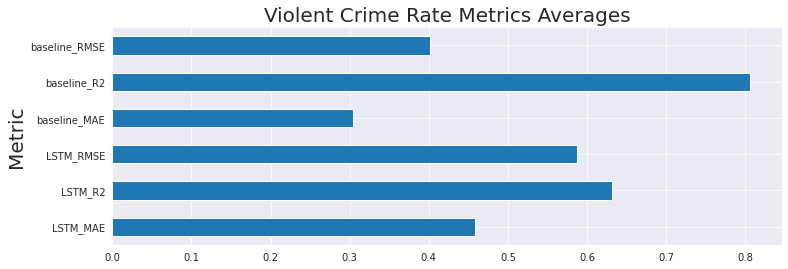

In [8]:
with sns.axes_style('darkgrid'):
    vscores.melt(id_vars=['state','crime_rate'],
                 value_vars=['baseline_MAE', 'LSTM_MAE','baseline_RMSE','LSTM_RMSE', 'baseline_R2','LSTM_R2'],
                 var_name=['metric']).groupby('metric')['value'].mean().plot(kind='barh',figsize=(12,4))
    plt.title('Violent Crime Rate Metrics Averages',size=20)
    plt.ylabel('Metric',size=20);

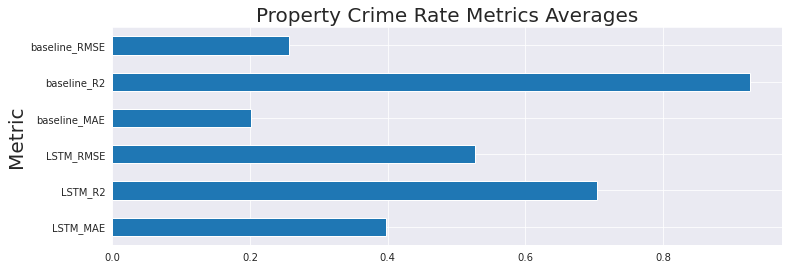

In [9]:
with sns.axes_style('darkgrid'):
    pscores.melt(id_vars=['state','crime_rate'],
                 value_vars=['baseline_MAE', 'LSTM_MAE','baseline_RMSE','LSTM_RMSE', 'baseline_R2','LSTM_R2'],
                 var_name=['metric']).groupby('metric')['value'].mean().plot(kind='barh',figsize=(12,4));
    plt.title('Property Crime Rate Metrics Averages',size=20)
    plt.ylabel('Metric',size=20);

In [10]:
#our best on violent_crime_1000
vscores[['state','baseline_MAE','LSTM_MAE','MAE_delta']].sort_values('MAE_delta',ascending=True).head(3)

,state,baseline_MAE,LSTM_MAE,MAE_delta
20,HI,0.863369,0.654945,-0.208425
88,VT,0.475830,0.501866,0.026036
98,WY,0.469128,0.500480,0.031353


In [11]:
#our worst on violent_crime_1000
vscores[['state','baseline_MAE','LSTM_MAE','MAE_delta']].sort_values('MAE_delta',ascending=True).tail(3)

,state,baseline_MAE,LSTM_MAE,MAE_delta
90,VA,0.194888,0.555343,0.360455
66,ND,0.138050,0.504686,0.366636
24,IL,0.166396,0.706267,0.539871


In [12]:
#our best on property_crime_1000
pscores[['state','baseline_MAE','LSTM_MAE','MAE_delta']].sort_values('MAE_delta',ascending=True).head(3)

,state,baseline_MAE,LSTM_MAE,MAE_delta
19,GA,0.231104,0.264822,0.033718
53,NE,0.210368,0.252312,0.041944
61,NM,0.191885,0.255635,0.063750


In [13]:
#our worst on property_crime_1000
pscores[['state','baseline_MAE','LSTM_MAE','MAE_delta']].sort_values('MAE_delta',ascending=True).tail(3)

,state,baseline_MAE,LSTM_MAE,MAE_delta
69,OH,0.182846,0.519661,0.336815
31,KS,0.229535,0.575499,0.345965
11,CO,0.127469,0.512010,0.384541


In [14]:
scores[(scores['state']=='HI') & (scores['crime_rate']=='violent_crime_1000')]['baseline_MAE'].values[0]

0.8633694905975072

---

## Plot some of the best and worst models:

In [15]:
def plot_lstm(state, crime, fullname):
    ele = [np.nan] #empty list element
    state_df = df.copy()
    state_df = state_df[state_df['state_abbr']==state]
    state_df['year'] = pd.to_datetime(state_df['year'], format='%Y')
    state_df.set_index('year',inplace=True)
    state_df = state_df.append(pd.Series(name=years[-1],dtype='float64'))
    baseline = state_df[crime][:-1]
    state_df['baseline'] = ele + [x for x in baseline]
    state_df['lstm'] = ele + [x for x in predictions[(predictions['state']==state) & (predictions['crime_rate']==crime)]['prediction']]
    baseline_mae = scores[(scores['state']==state) & (scores['crime_rate']==crime)]['baseline_MAE'].values[0]
    lstm_mae = scores[(scores['state']==state) & (scores['crime_rate']==crime)]['LSTM_MAE'].values[0]
    #finally, plot:
    with sns.axes_style('darkgrid'):
        state_df[[crime,'baseline','lstm']].plot(marker='X', figsize=(15,5))
        plt.title(f'{fullname} ({state}) Baseline MAE = {baseline_mae:.3f}, LSTM MAE = {lstm_mae:.3f}', size=20)
        plt.ylabel(f'{crime.replace("_"," ").replace("1000","").title()} per 1,000 pop.', size=14)
        plt.xlabel('Year', size=12);

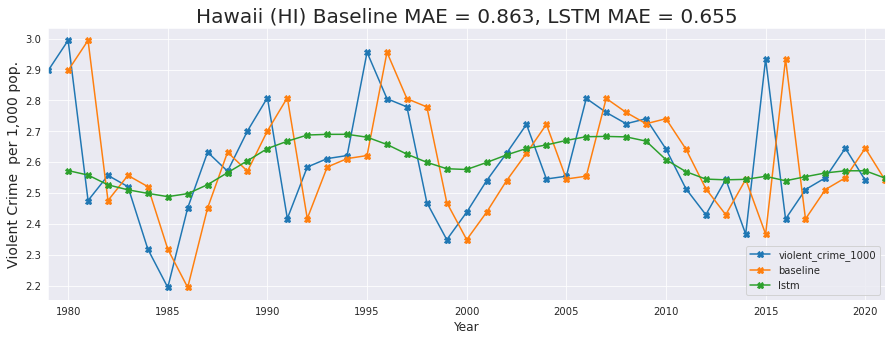

In [16]:
plot_lstm('HI','violent_crime_1000', 'Hawaii')

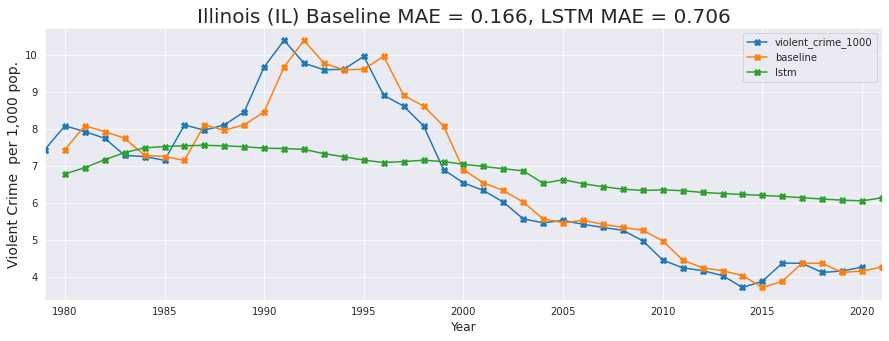

In [17]:
plot_lstm('IL','violent_crime_1000', 'Illinois')

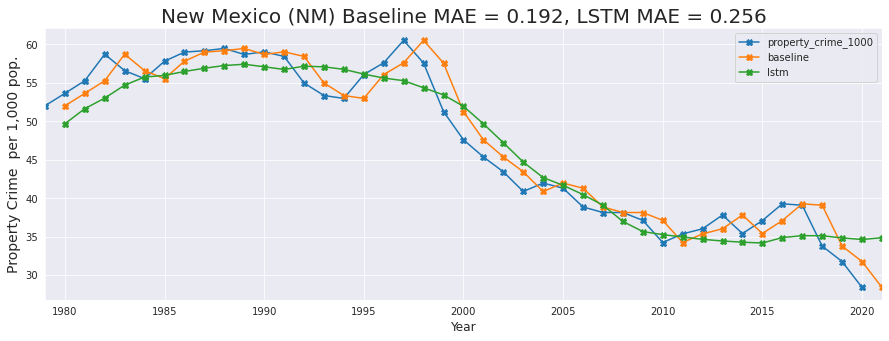

In [18]:
plot_lstm('NM','property_crime_1000', 'New Mexico')

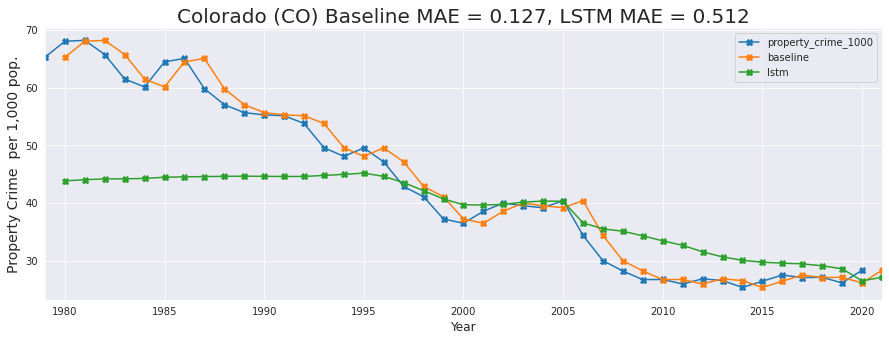

In [19]:
plot_lstm('CO','property_crime_1000', 'Colorado')

---

## Conclusions

So our model in most cases underperforms compared to the baseline model. However, it achieves better predictive power and comparatively less error than the ARIMAX method.

**Bright Spots**

* The RNN method had less stringent requirements for meeting classical modeling assumptions.
* The baseline method was a high bar to beat with this kind of data. We think our model could do a lot better with more data to learn from!

**Limitations**

* As a black-box deep learning specification, it’s difficult to tell which of the features conveyed the most importance to predicting crime rates.

* Limited frequency of data and small number of observations likely does not give the model enough to train on.

* A next attempt should incorporate more data, but perhaps also attempt an advanced technique like autoregressive recurrence.

